# Assignment 1: Polarization Detection - EDA
## SemEval 2026 Task 9, Subtask 1 (POLAR)
### CS-272: Artificial Intelligence



---

<font size = "5"><b>
Anum Fatima ___
515458</b></font>


---



In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 35.5 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=3e439fe38588aff4afc09dccc95280c1f684a29f6f875d1bb59bca09603bacd1
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect




---


<font size = "5">Importing all the needed modules.</font>


---





In [2]:
import chardet
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages

from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True



---


<font size = "5">Checking the encodings of the languages</font>


---



In [ ]:

with open("spa.csv", 'rb') as f:
    result = chardet.detect(f.read(100000))
result
# with open("spa.csv", 'rb') as f:   # open in binary mode (b)
#     result = chardet.detect(f.read(100000))  # read first 100k bytes
# result
# with open("spa.csv", 'rb') as f:   # open in binary mode (b)
#     result = chardet.detect(f.read(100000))  # read first 100k bytes
# result

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [ ]:
df_eng = pd.read_csv("data/eng.csv", encoding="Windows-1252")
# Separate English texts by label using 0 and 1
polarized_texts = df_eng[df_eng['polarization'] == 1]['text']
not_polarized_texts = df_eng[df_eng['polarization'] == 0]['text']

# Quick check
print("Number of polarized texts:", len(polarized_texts))
print("Number of not polarized texts:", len(not_polarized_texts))



---


<font size="5">Finding the most common words: </font>


---





> English



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


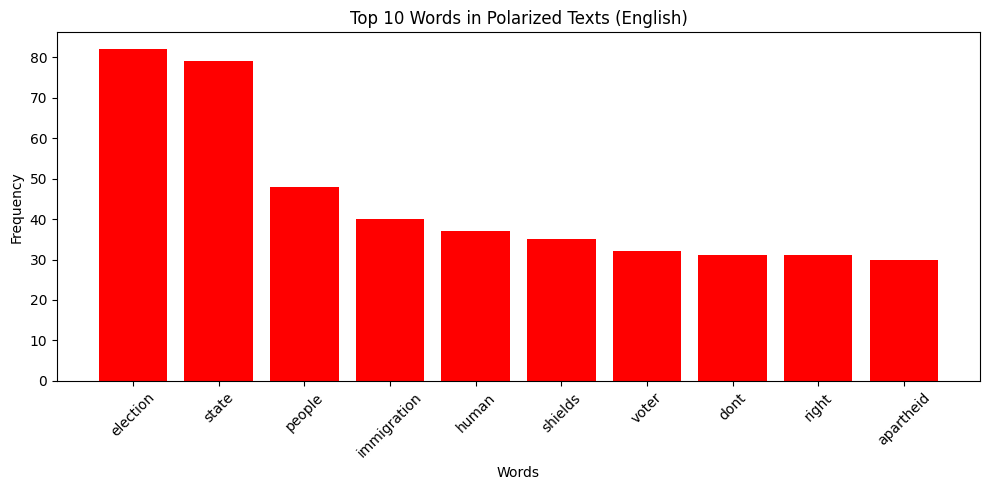

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

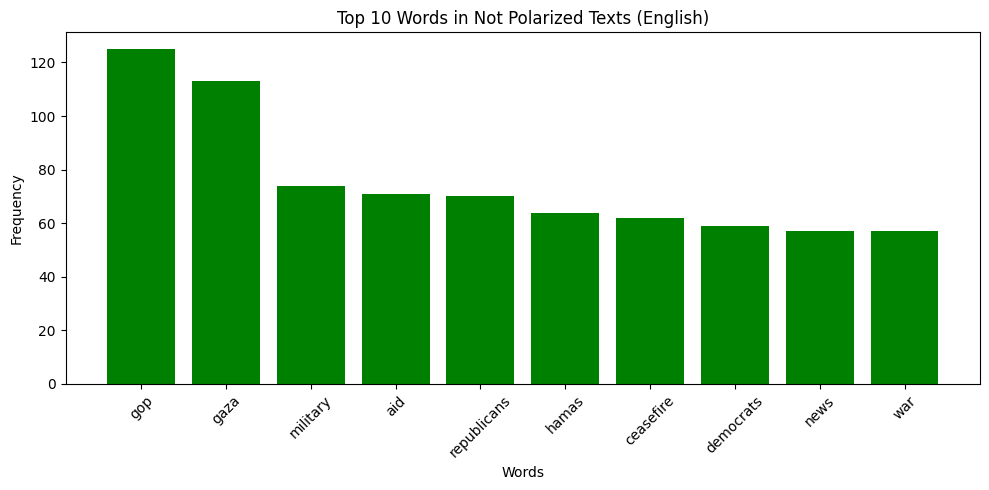

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from google.colab import files

# Make sure the folder exists
os.makedirs("plots", exist_ok=True)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

def clean_and_tokenize_english(text_series, stopwords_list, regex_pattern):
    from nltk.tokenize import word_tokenize

    text = " ".join(text_series.astype(str))
    text = text.lower()
    text = re.sub(regex_pattern, " ", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_list and len(t) > 2]
    return tokens
stop_words = set(stopwords.words('english'))
stop_words.add("trump")
stop_words.add("ukraine")
stop_words.add("joe")
stop_words.add("biden")
stop_words.add("states")
stop_words.add("like")
stop_words.add("israel")
stop_words.add("donald")
stop_words.add("don't")
stop_words.add("would") #because states and state are both present
 #adding these to the stop_words because they are common in polarized and non-polarized
#so they do not give any important insight
# Process English data
df_eng = pd.read_csv('eng.csv',encoding='Windows-1252')
polarized_words = clean_and_tokenize_english(
    df_eng[df_eng['polarization'] == 1]['text'],
    stop_words,
    r'[^a-z\s]'
)
not_polarized_words = clean_and_tokenize_english(
    df_eng[df_eng['polarization'] == 0]['text'],
    stop_words,
    r'[^a-z\s]'
)

polarized_counter = Counter(polarized_words)
not_polarized_counter = Counter(not_polarized_words)

top_polarized = polarized_counter.most_common(10)
top_not_polarized = not_polarized_counter.most_common(10)

words_pol, counts_pol = zip(*top_polarized)
words_not, counts_not = zip(*top_not_polarized)

# Polarized Plot
plt.figure(figsize=(10, 5))
plt.bar(words_pol, counts_pol, color='red')
plt.title("Top 10 Words in Polarized Texts (English)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/eng_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/eng_polarized_top_words.pdf")

# Not Polarized Plot
plt.figure(figsize=(10, 5))
plt.bar(words_not, counts_not, color='green')
plt.title("Top 10 Words in Not Polarized Texts (English)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/eng_not_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/eng_not_polarized_top_words.pdf")



> Spanish



Number of polarized texts: 1660
Number of not polarized texts: 1645


/tmp/ipython-input-4086898844.py:47: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4086898844.py:47: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4086898844.py:48: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-4086898844.py:48: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-4086898844.py:48: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_polarized_top_words.pdf", format="pdf", bbox_inches="tight"

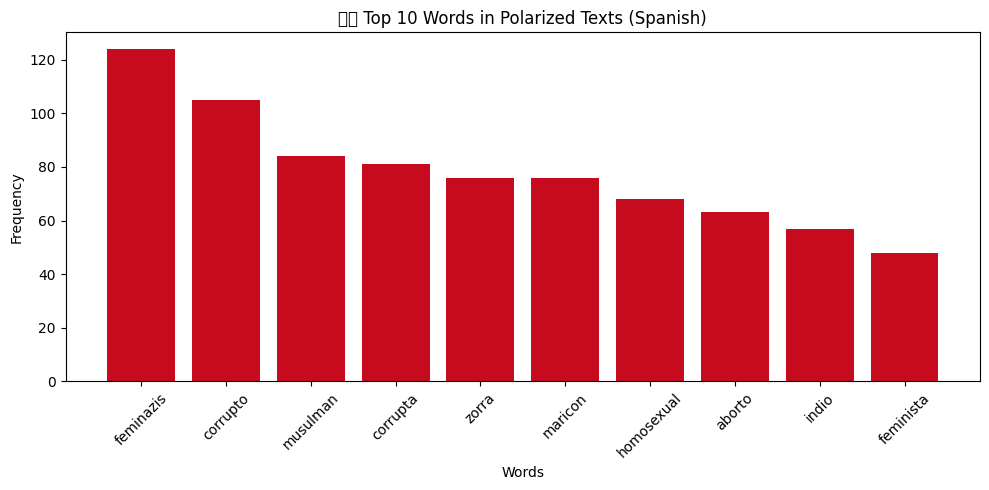

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-4086898844.py:59: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4086898844.py:59: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4086898844.py:60: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_not_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-4086898844.py:60: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_not_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-4086898844.py:60: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_not_polarized_top_words.pdf", format="pdf", bbox_in

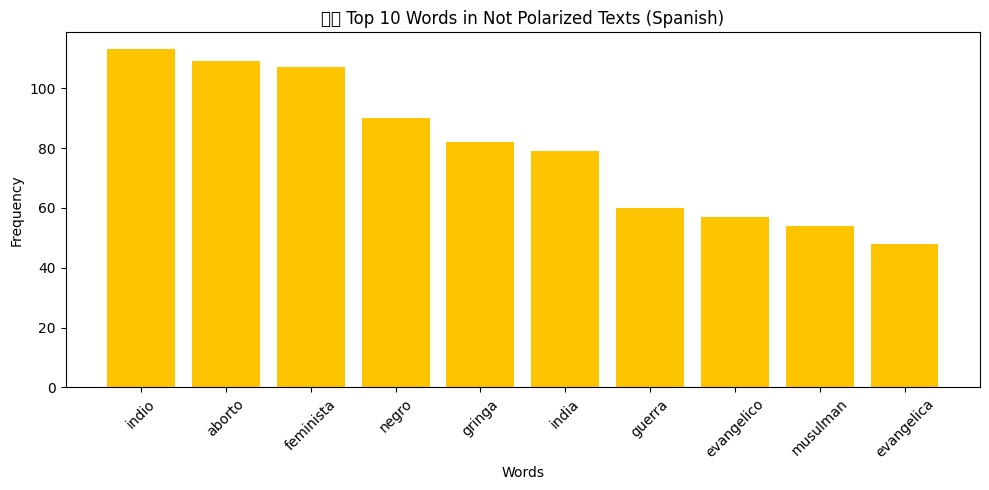

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
df_spa = pd.read_csv("spa.csv", encoding="utf-8-sig")

polarized_texts = df_spa[df_spa['polarization'] == 1]['text']
not_polarized_texts = df_spa[df_spa['polarization'] == 0]['text']

print(f"Number of polarized texts: {len(polarized_texts)}")
print(f"Number of not polarized texts: {len(not_polarized_texts)}")

stop_words_spa = set(stopwords.words('spanish') + [
    'sí', 'no', 'bueno', 'pues', 'entonces', 'ahora', 'así', 'vale',
    'eh', 'oye', 'claro', 'ya', 'tan', 'aquí', 'allí', 'solo', 'también', "judio",
    "indigena","abortar","mas",'corrupcion','israel','islam','ser'
])

def clean_and_tokenize_spanish(text_series, stop_words):
    words = []
    for text in text_series:
        text = str(text).lower()
        text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        words.extend(tokens)
    return words

# Process Spanish words
polarized_words_spa = clean_and_tokenize_spanish(polarized_texts, stop_words_spa)
not_polarized_words_spa = clean_and_tokenize_spanish(not_polarized_texts, stop_words_spa)

# Count frequencies
polarized_counter_spa = Counter(polarized_words_spa)
not_polarized_counter_spa = Counter(not_polarized_words_spa)

# Top 10 words
top_polarized_spa = polarized_counter_spa.most_common(10)
top_not_polarized_spa = not_polarized_counter_spa.most_common(10)

words_pol_spa, counts_pol_spa = zip(*top_polarized_spa)
words_not_spa, counts_not_spa = zip(*top_not_polarized_spa)

# Polarized Plot
plt.figure(figsize=(10, 5))
plt.bar(words_pol_spa, counts_pol_spa, color='#C60B1E')
plt.title("🇪🇸 Top 10 Words in Polarized Texts (Spanish)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/spanish_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/spanish_polarized_top_words.pdf")

# Not Polarized Plot
plt.figure(figsize=(10, 5))
plt.bar(words_not_spa, counts_not_spa, color='#FFC400')
plt.title("🇪🇸 Top 10 Words in Not Polarized Texts (Spanish)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/spanish_not_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/spanish_not_polarized_top_words.pdf")



> German



Number of polarized texts: 1512
Number of not polarized texts: 1668


/tmp/ipython-input-2002973399.py:49: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2002973399.py:49: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2002973399.py:50: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-2002973399.py:50: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-2002973399.py:50: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
/

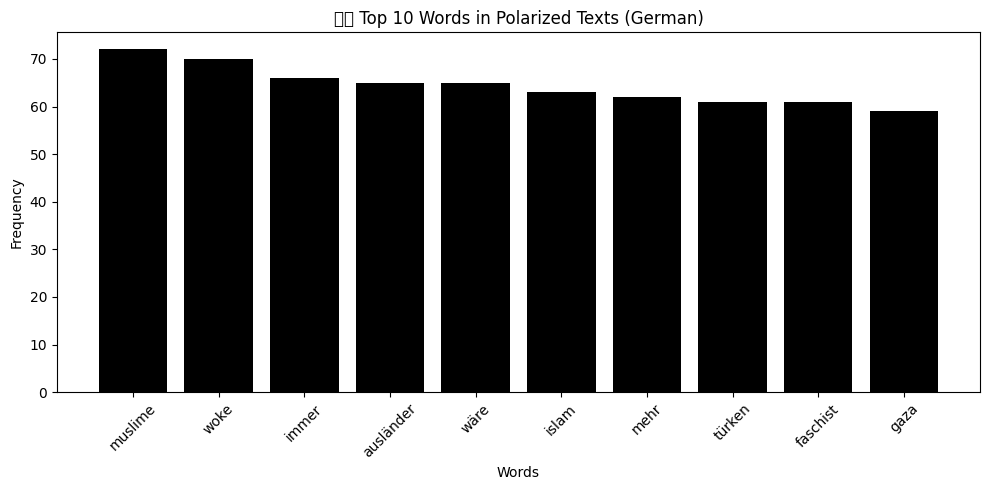

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2002973399.py:61: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2002973399.py:61: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2002973399.py:62: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_not_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-2002973399.py:62: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_not_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-2002973399.py:62: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_not_polarized_top_words.pdf", format="pdf", bbox_inche

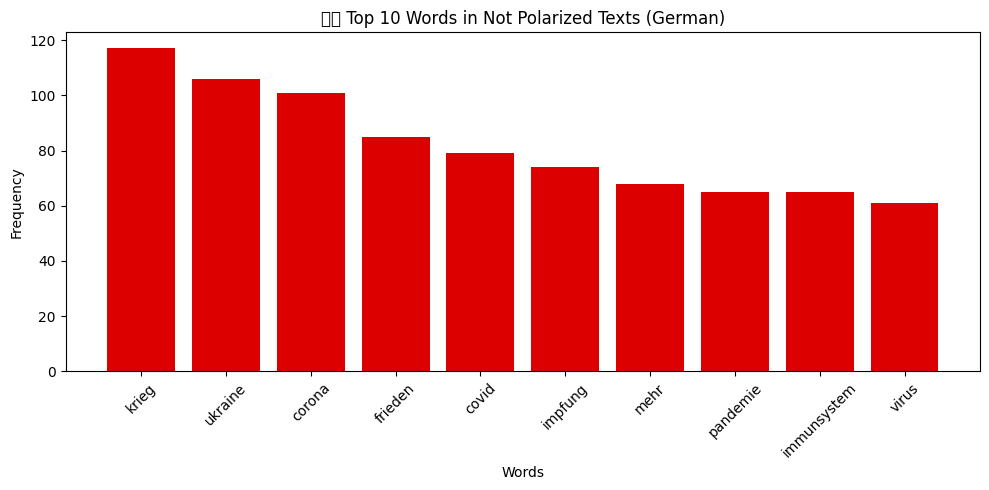

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
df_ger = pd.read_csv("deu.csv", encoding="utf-8-sig")
os.makedirs("plots", exist_ok=True)
polarized_texts_ger = df_ger[df_ger['polarization'] == 1]['text']
not_polarized_texts_ger = df_ger[df_ger['polarization'] == 0]['text']

print(f"Number of polarized texts: {len(polarized_texts_ger)}")
print(f"Number of not polarized texts: {len(not_polarized_texts_ger)}")

stop_words_ger = set(stopwords.words('german') + [
    'dass', 'mal', 'halt', 'einfach', 'eigentlich', 'wirklich',
    'ganz', 'natürlich', 'schon', 'doch', 'eben', 'ja', "russland","israel","hamas"
])

def clean_and_tokenize_german(text_series, stop_words):
    words = []
    for text in text_series:
        text = str(text).lower()
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'www\S+', '', text)
        text = re.sub(r'[^a-zäöüß\s]', '', text)
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        words.extend(tokens)
    return words

# Process German words
polarized_words_ger = clean_and_tokenize_german(polarized_texts_ger, stop_words_ger)
not_polarized_words_ger = clean_and_tokenize_german(not_polarized_texts_ger, stop_words_ger)

# Count frequencies
polarized_counter_ger = Counter(polarized_words_ger)
not_polarized_counter_ger = Counter(not_polarized_words_ger)

# Top 10 words
top_polarized_ger = polarized_counter_ger.most_common(10)
top_not_polarized_ger = not_polarized_counter_ger.most_common(10)

words_pol_ger, counts_pol_ger = zip(*top_polarized_ger)
words_not_ger, counts_not_ger = zip(*top_not_polarized_ger)

# Polarized Plot
plt.figure(figsize=(10, 5))
plt.bar(words_pol_ger, counts_pol_ger, color='#000000')
plt.title("🇩🇪 Top 10 Words in Polarized Texts (German)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/german_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/german_polarized_top_words.pdf")

# Not Polarized Plot
plt.figure(figsize=(10, 5))
plt.bar(words_not_ger, counts_not_ger, color='#DD0000')
plt.title("🇩🇪 Top 10 Words in Not Polarized Texts (German)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/german_not_polarized_top_words.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/german_not_polarized_top_words.pdf")




> Overall (in all languages)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



--- ENG ---
Top words in polarized: [('election', 82), ('state', 79), ('states', 51), ('people', 48), ('immigration', 40)]
Top words in not polarized: [('gop', 124), ('gaza', 113), ('us', 75), ('military', 74), ('aid', 71)]

--- DEU ---
Top words in polarized: [('muslime', 72), ('woke', 70), ('immer', 66), ('ausländer', 65), ('wäre', 65)]
Top words in not polarized: [('krieg', 117), ('ukraine', 106), ('corona', 101), ('schon', 93), ('frieden', 85)]

--- SPA ---
Top words in polarized: [('feminazis', 124), ('corrupto', 105), ('musulman', 84), ('corrupta', 81), ('zorra', 76)]
Top words in not polarized: [('indio', 113), ('aborto', 109), ('feminista', 107), ('negro', 90), ('gringa', 82)]

=== Overall Top Words Across All Languages ===
Polarized: [('feminazis', 124), ('corrupto', 105), ('woke', 97), ('gaza', 85), ('musulman', 84), ('election', 82), ('corrupta', 81), ('state', 80), ('putin', 77), ('zorra', 76)]
Not Polarized: [('gaza', 160), ('gop', 124), ('krieg', 117), ('indio', 113), ('

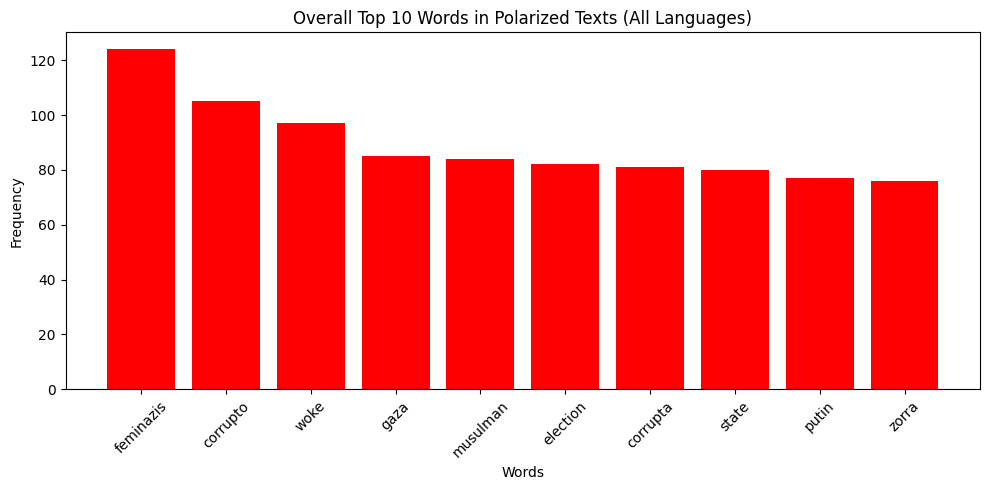

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

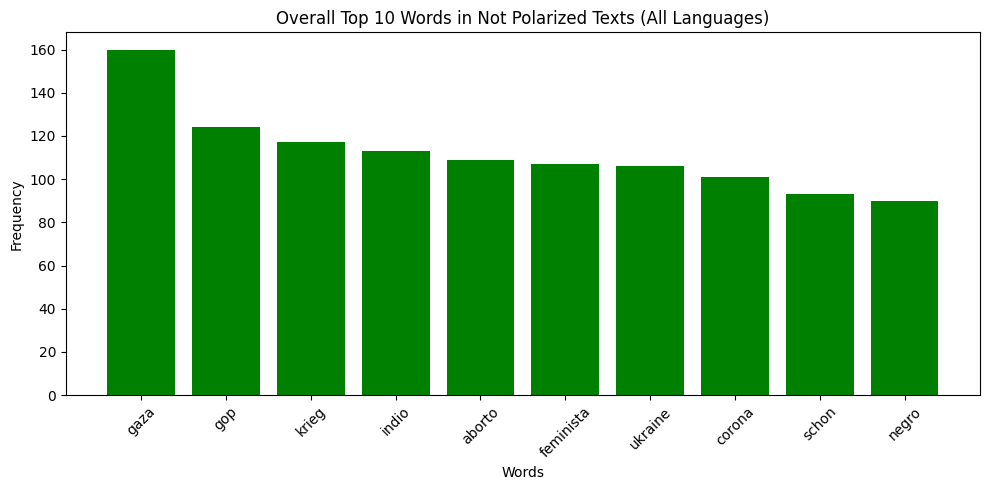

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
nltk.download('stopwords')

df_eng = pd.read_csv("eng.csv", encoding="windows-1252")
df_deu = pd.read_csv("deu.csv", encoding="utf-8-sig")
df_spa = pd.read_csv("spa.csv", encoding="utf-8-sig")

lang_map = {
    'eng': {'df': df_eng, 'stopwords': stopwords.words('english')+['trump','ukraine','donald','joe','biden','don\'t','would','like','israel'], 'regex': r'[^a-z\s]'},
    'deu': {'df': df_deu, 'stopwords': stopwords.words('german') + ['ja','user','nein','mal','also','russland', 'israel', 'hamas',], 'regex': r'[^a-zäöüß\s]'},
    'spa': {'df': df_spa, 'stopwords': stopwords.words('spanish')+["judio",'si','ser',"indigena", "abortar", "mas",'islam','corrupcion','israel' ], 'regex': r'[^a-záéíóúüñ\s]'}
}

def clean_and_tokenize(text_series, stop_words, regex):
    words = []
    for text in text_series:
        text = str(text).lower()
        text = re.sub(regex, '', text)
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        words.extend(tokens)
    return words

overall_polarized = Counter()
overall_not_polarized = Counter()

for lang, info in lang_map.items():
    df_lang = info['df']
    stop_words = set(info['stopwords'])
    regex = info['regex']

    polarized_texts = df_lang[df_lang['polarization'] == 1]['text']
    not_polarized_texts = df_lang[df_lang['polarization'] == 0]['text']

    polarized_words = clean_and_tokenize(polarized_texts, stop_words, regex)
    not_polarized_words = clean_and_tokenize(not_polarized_texts, stop_words, regex)

    pol_counter = Counter(polarized_words)
    not_pol_counter = Counter(not_polarized_words)

    overall_polarized.update(pol_counter)
    overall_not_polarized.update(not_pol_counter)

    print(f"\n--- {lang.upper()} ---")
    print("Top words in polarized:", pol_counter.most_common(5))
    print("Top words in not polarized:", not_pol_counter.most_common(5))

top_pol_overall = overall_polarized.most_common(10)
top_not_overall = overall_not_polarized.most_common(10)

print("\n=== Overall Top Words Across All Languages ===")
print("Polarized:", top_pol_overall)
print("Not Polarized:", top_not_overall)

# create folder if not exists
os.makedirs("plots", exist_ok=True)

# Separate words and counts
words_pol, counts_pol = zip(*top_pol_overall)
words_not, counts_not = zip(*top_not_overall)

# Polarized bar chart
plt.figure(figsize=(10,5))
plt.bar(words_pol, counts_pol, color='red')
plt.title("Overall Top 10 Words in Polarized Texts (All Languages)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/overall_common_polarized.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/overall_common_polarized.pdf")

# Not polarized bar chart
plt.figure(figsize=(10,5))
plt.bar(words_not, counts_not, color='green')
plt.title("Overall Top 10 Words in Not Polarized Texts (All Languages)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/overall_common_not_polarized.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/overall_common_not_polarized.pdf")



---


<font size = "5">Counting ratio of uppercase and lowercase letters:</font>


---





> English



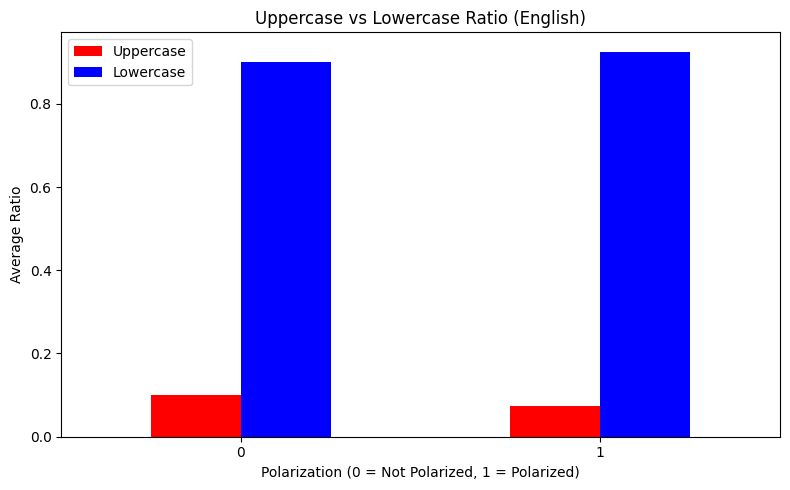

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
def count_case_ratio(text):
    text = str(text)
    total_letters = sum(c.isalpha() for c in text)
    if total_letters == 0:
        return 0, 0
    upper = sum(c.isupper() for c in text)
    lower = sum(c.islower() for c in text)
    return upper / total_letters, lower / total_letters

# apply on english data
df_eng['upper_ratio'], df_eng['lower_ratio'] = zip(*df_eng['text'].astype(str).apply(count_case_ratio))

# get average ratios for polarized and not polarized
avg_ratios_eng = df_eng.groupby('polarization')[['upper_ratio', 'lower_ratio']].mean()

# create folder if not exists
os.makedirs("plots", exist_ok=True)

# plot and save
avg_ratios_eng.plot(kind='bar', figsize=(8,5), color=['red', 'blue'])
plt.title("Uppercase vs Lowercase Ratio (English)")
plt.ylabel("Average Ratio")
plt.xlabel("Polarization (0 = Not Polarized, 1 = Polarized)")
plt.xticks(rotation=0)
plt.legend(["Uppercase", "Lowercase"])
plt.tight_layout()

plt.savefig("plots/eng_case_ratio.pdf", format="pdf", bbox_inches="tight")  # save as pdf
plt.show()

files.download("plots/eng_case_ratio.pdf")  # for colab




> German



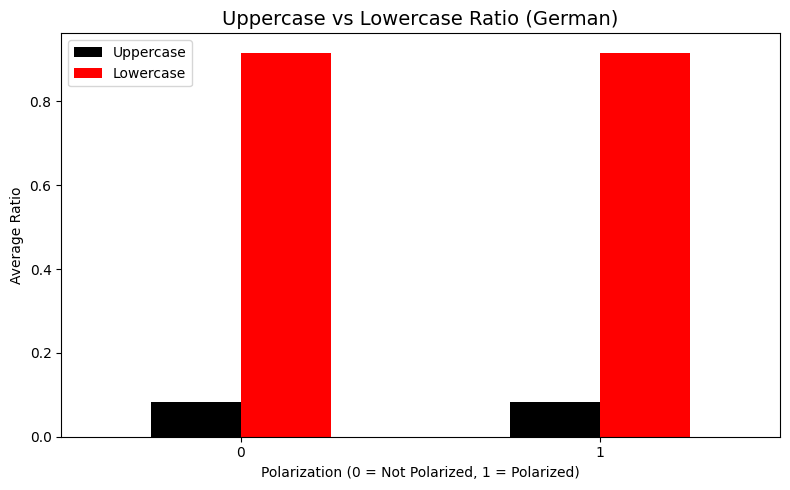

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
df_deu['upper_ratio'], df_deu['lower_ratio'] = zip(*df_deu['text'].astype(str).apply(count_case_ratio))

avg_ratios_deu = df_deu.groupby('polarization')[['upper_ratio', 'lower_ratio']].mean()

os.makedirs("plots", exist_ok=True)

avg_ratios_deu.plot(kind='bar', figsize=(8,5), color=['black', '#FF0000'])  # black = uppercase, red = lowercase
plt.title("Uppercase vs Lowercase Ratio (German)", fontsize=14)
plt.ylabel("Average Ratio")
plt.xlabel("Polarization (0 = Not Polarized, 1 = Polarized)")
plt.xticks(rotation=0)
plt.legend(["Uppercase", "Lowercase"])
plt.tight_layout()

plt.savefig("plots/deu_case_ratio.pdf", format="pdf", bbox_inches="tight")  # save as pdf
plt.show()

files.download("plots/deu_case_ratio.pdf")  # for colab download




> Spanish



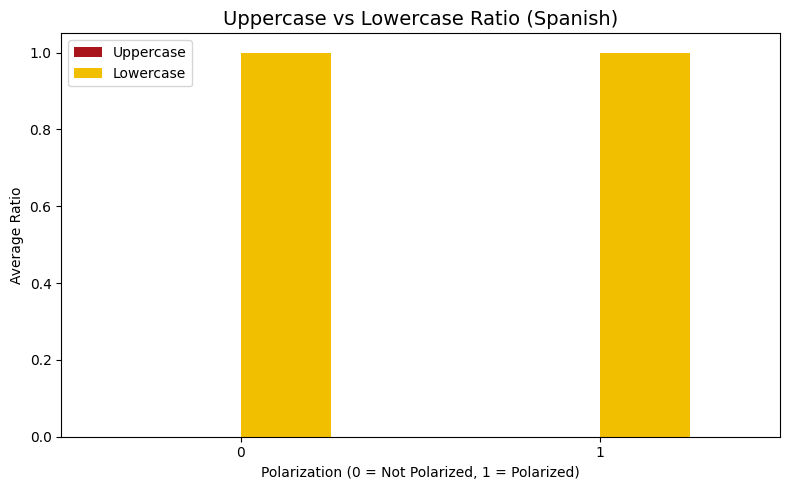

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
df_spa['upper_ratio'], df_spa['lower_ratio'] = zip(*df_spa['text'].astype(str).apply(count_case_ratio))

avg_ratios_spa = df_spa.groupby('polarization')[['upper_ratio', 'lower_ratio']].mean()

os.makedirs("plots", exist_ok=True)

avg_ratios_spa.plot(kind='bar', figsize=(8,5), color=['#AA151B', '#F1BF00'])  # red & yellow (Spain flag)
plt.title("Uppercase vs Lowercase Ratio (Spanish)", fontsize=14)
plt.ylabel("Average Ratio")
plt.xlabel("Polarization (0 = Not Polarized, 1 = Polarized)")
plt.xticks(rotation=0)
plt.legend(["Uppercase", "Lowercase"])
plt.tight_layout()

plt.savefig("plots/spa_case_ratio.pdf", format="pdf", bbox_inches="tight")  # save to pdf
plt.show()

files.download("plots/spa_case_ratio.pdf")  # for colab download




> Overall (in all languages)



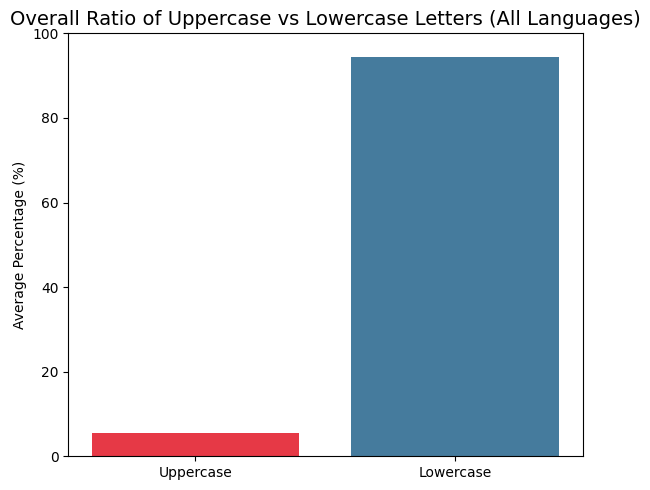

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
df_eng = pd.read_csv("eng.csv", encoding="Windows-1252")
df_deu = pd.read_csv("deu.csv", encoding="utf-8-sig")
df_spa = pd.read_csv("spa.csv", encoding="utf-8-sig")

# Combine them
data = pd.concat([df_eng, df_deu, df_spa], ignore_index=True)

# Apply existing function
ratios = data['text'].apply(count_case_ratio)

# Separate into uppercase and lowercase ratios
upper_ratios = [u for u, l in ratios]
lower_ratios = [l for u, l in ratios]

# Compute average ratios overall
avg_upper = sum(upper_ratios) / len(upper_ratios) * 100
avg_lower = sum(lower_ratios) / len(lower_ratios) * 100

# Create plots folder if missing
os.makedirs("plots", exist_ok=True)

# Plot
plt.figure(figsize=(6,5))
plt.bar(['Uppercase', 'Lowercase'], [avg_upper, avg_lower],
        color=['#e63946', '#457b9d'])
plt.title("Overall Ratio of Uppercase vs Lowercase Letters (All Languages)", fontsize=14)
plt.ylabel("Average Percentage (%)")
plt.ylim(0, 100)
plt.tight_layout()

# Save + show + download
plt.savefig("plots/overall_case_ratio.pdf", format="pdf", bbox_inches="tight")
plt.show()

files.download("plots/overall_case_ratio.pdf")




---


<font size = "5">Word clouds:</font>


---





> English



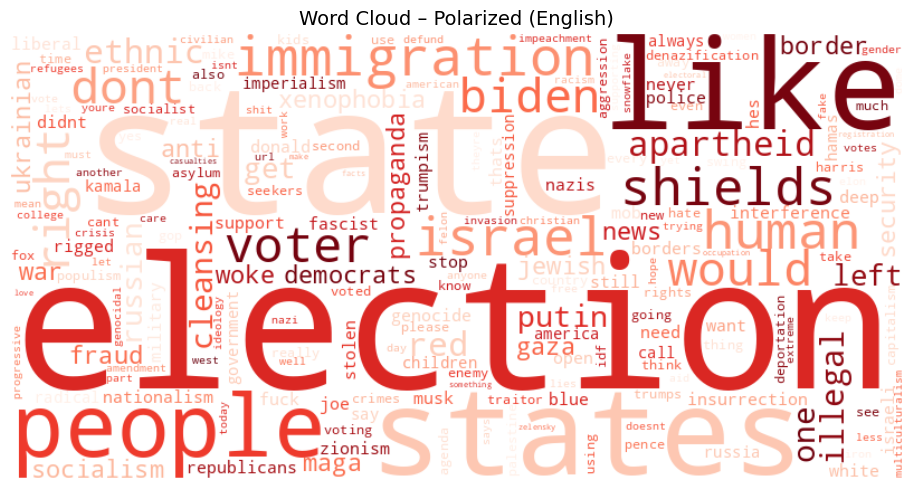

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

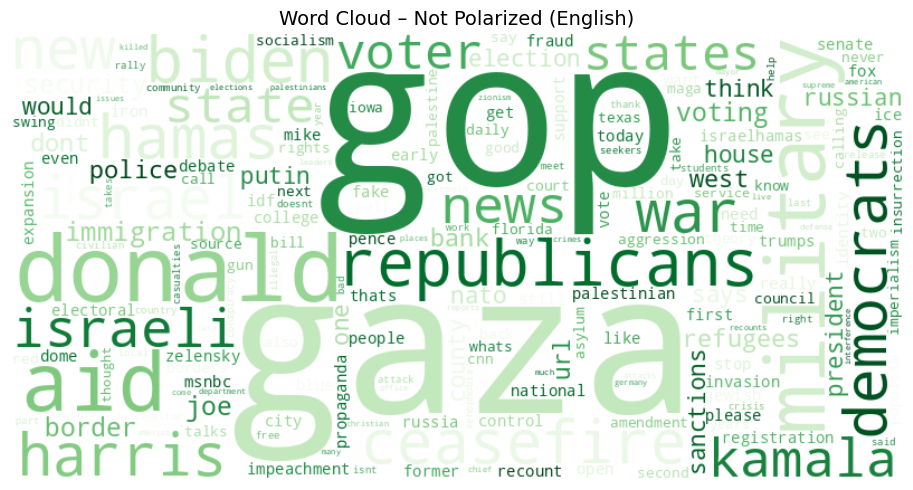

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
df_eng = pd.read_csv("eng.csv", encoding="windows-1252")

stop_words_eng = set(stopwords.words('english'))
stop_words_eng.add('trump')
stop_words_eng.add('ukraine')
stop_words.add("joe")
stop_words.add("biden")
stop_words.add("states")
stop_words.add("like")
stop_words.add("israel")
stop_words.add("donald")
stop_words.add("don't")
stop_words.add("would")

def clean_and_tokenize_english(text_series, stop_words):
    words = []
    for text in text_series:
        text = str(text).lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        words.extend(tokens)
    return words

polarized_words_eng = clean_and_tokenize_english(
    df_eng[df_eng['polarization'] == 1]['text'],
    stop_words_eng
)
not_polarized_words_eng = clean_and_tokenize_english(
    df_eng[df_eng['polarization'] == 0]['text'],
    stop_words_eng
)

polarized_counter_eng = Counter(polarized_words_eng)
not_polarized_counter_eng = Counter(not_polarized_words_eng)

# Polarized word cloud
wc_polarized_en = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Reds'
).generate_from_frequencies(polarized_counter_eng)

plt.figure(figsize=(10, 5))
plt.imshow(wc_polarized_en, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Polarized (English)", fontsize=14)
plt.tight_layout()
plt.savefig("plots/english_wordcloud_polar.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/english_wordcloud_polar.pdf")

# Not polarized word cloud
wc_not_polarized_en = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Greens'
).generate_from_frequencies(not_polarized_counter_eng)

plt.figure(figsize=(10, 5))
plt.imshow(wc_not_polarized_en, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Not Polarized (English)", fontsize=14)
plt.tight_layout()
plt.savefig("plots/english_wordcloud_nonpolar.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/english_wordcloud_nonpolar.pdf")



> German



/tmp/ipython-input-1928281026.py:46: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1928281026.py:46: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1928281026.py:47: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_wordcloud_polar.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-1928281026.py:47: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_wordcloud_polar.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-1928281026.py:47: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_wordcloud_polar.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-

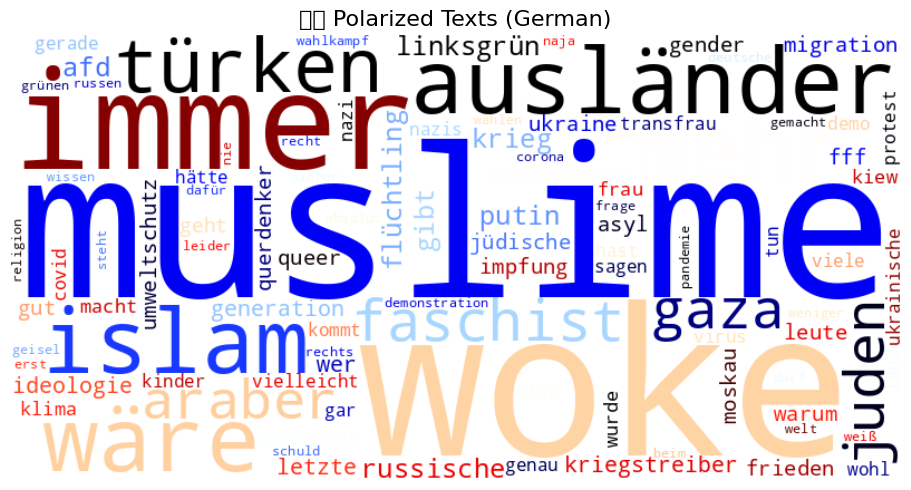

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1928281026.py:63: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1928281026.py:63: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1928281026.py:64: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_wordcloud_nonpolar.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-1928281026.py:64: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_wordcloud_nonpolar.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-1928281026.py:64: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/german_wordcloud_nonpolar.pdf", format="pdf", bbox_inches="tight")
/tmp

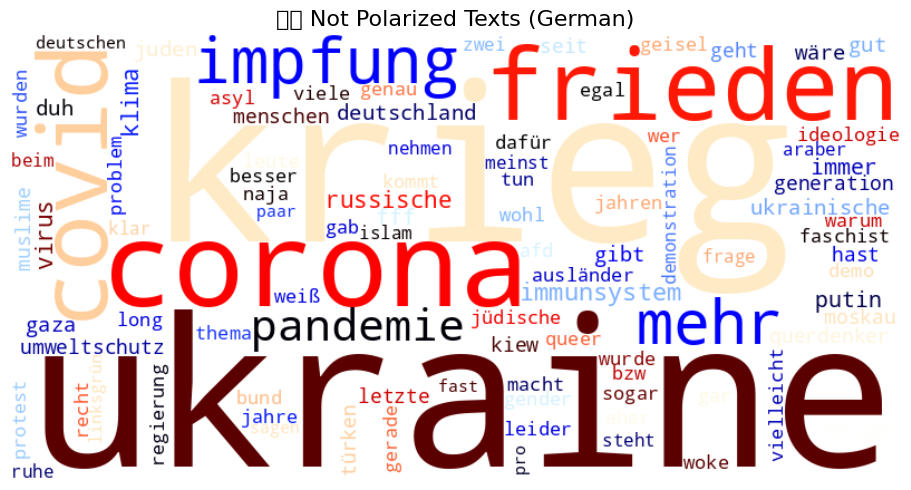

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_deu = pd.read_csv("deu.csv", encoding="utf-8-sig")

stop_words_deu = set(stopwords.words('german') + [
    'ja', 'nein', 'mal', 'also', 'dass', 'halt', 'einfach',
    'eigentlich', 'wirklich', 'ganz', 'natürlich', 'schon', 'doch', 'eben','russland', 'israel', 'hamas'
    ,'user'
])

def clean_and_tokenize_german(text_series, stop_words):
    words = []
    for text in text_series:
        text = str(text).lower()
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'www\S+', '', text)
        text = re.sub(r'[^a-zäöüß\s]', '', text)
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        words.extend(tokens)
    return words

polarized_words_deu = clean_and_tokenize_german(
    df_deu[df_deu['polarization'] == 1]['text'],
    stop_words_deu
)
not_polarized_words_deu = clean_and_tokenize_german(
    df_deu[df_deu['polarization'] == 0]['text'],
    stop_words_deu
)

polarized_counter_deu = Counter(polarized_words_deu)
not_polarized_counter_deu = Counter(not_polarized_words_deu)

# Polarized (German)
wordcloud_pol_deu = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='flag',
    max_words=100
).generate_from_frequencies(polarized_counter_deu)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pol_deu, interpolation='bilinear')
plt.axis("off")
plt.title("🇩🇪 Polarized Texts (German)", fontsize=16)
plt.tight_layout()
plt.savefig("plots/german_wordcloud_polar.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/german_wordcloud_polar.pdf")

# Not Polarized (German)
wordcloud_not_deu = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='flag',
    max_words=100
).generate_from_frequencies(not_polarized_counter_deu)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_not_deu, interpolation='bilinear')
plt.axis("off")
plt.title("🇩🇪 Not Polarized Texts (German)", fontsize=16)
plt.tight_layout()
plt.savefig("plots/german_wordcloud_nonpolar.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/german_wordcloud_nonpolar.pdf")



> Spanish



/tmp/ipython-input-2993066701.py:44: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2993066701.py:44: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2993066701.py:45: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_wordcloud_polar.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-2993066701.py:45: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_wordcloud_polar.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-2993066701.py:45: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_wordcloud_polar.pdf", format="pdf", bbox_inches="tight")
/tmp/ipyth

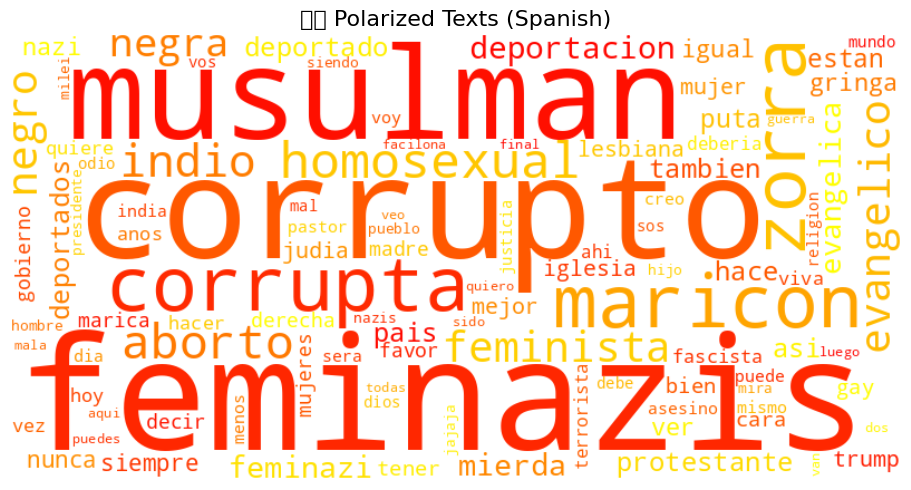

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2993066701.py:61: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2993066701.py:61: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2993066701.py:62: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_wordcloud_nonpolar.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-2993066701.py:62: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_wordcloud_nonpolar.pdf", format="pdf", bbox_inches="tight")
/tmp/ipython-input-2993066701.py:62: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig("plots/spanish_wordcloud_nonpolar.pdf", format="pdf", bbox_inches="tight")
/

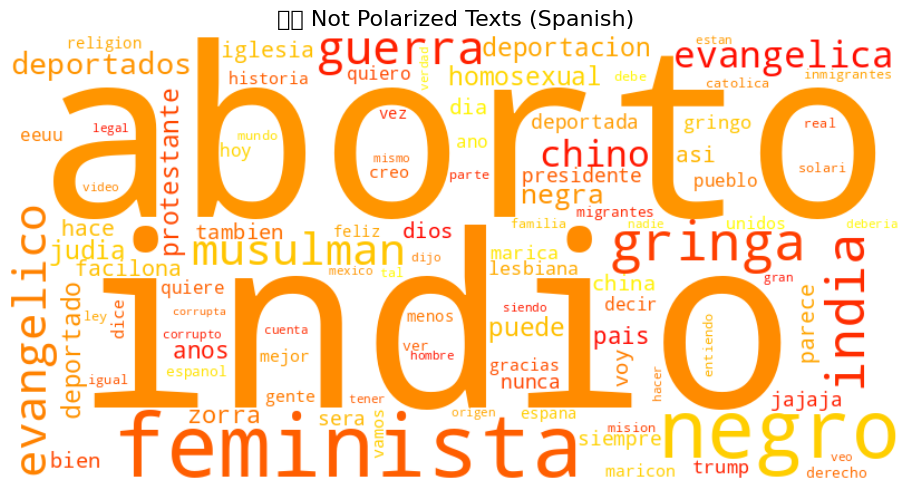

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load Spanish data
df_spa = pd.read_csv("spa.csv", encoding="utf-8-sig")

stop_words_spa = set(stopwords.words('spanish') + [
    'sí', 'no', 'bueno', 'pues', 'entonces', 'ahora', 'así', 'vale',
    'eh', 'oye', 'claro', 'ya', 'tan', 'aquí', 'allí', 'solo', 'también','judio', 'indigena', 'abortar', 'mas' ,
    'israel','islam','corrupcion','ser','si'
])

def clean_and_tokenize_spanish(text_series, stop_words):
    words = []
    for text in text_series:
        text = str(text).lower()
        text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        words.extend(tokens)
    return words

polarized_words_spa = clean_and_tokenize_spanish(
    df_spa[df_spa['polarization'] == 1]['text'],
    stop_words_spa
)
not_polarized_words_spa = clean_and_tokenize_spanish(
    df_spa[df_spa['polarization'] == 0]['text'],
    stop_words_spa
)

polarized_counter_spa = Counter(polarized_words_spa)
not_polarized_counter_spa = Counter(not_polarized_words_spa)

# Polarized (Spanish)
wordcloud_pol_spa = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='autumn',
    max_words=100
).generate_from_frequencies(polarized_counter_spa)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pol_spa, interpolation='bilinear')
plt.axis("off")
plt.title("🇪🇸 Polarized Texts (Spanish)", fontsize=16)
plt.tight_layout()
plt.savefig("plots/spanish_wordcloud_polar.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/spanish_wordcloud_polar.pdf")

# Not Polarized (Spanish)
wordcloud_not_spa = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='autumn',
    max_words=100
).generate_from_frequencies(not_polarized_counter_spa)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_not_spa, interpolation='bilinear')
plt.axis("off")
plt.title("🇪🇸 Not Polarized Texts (Spanish)", fontsize=16)
plt.tight_layout()
plt.savefig("plots/spanish_wordcloud_nonpolar.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/spanish_wordcloud_nonpolar.pdf")



> Overall (all languages combined)



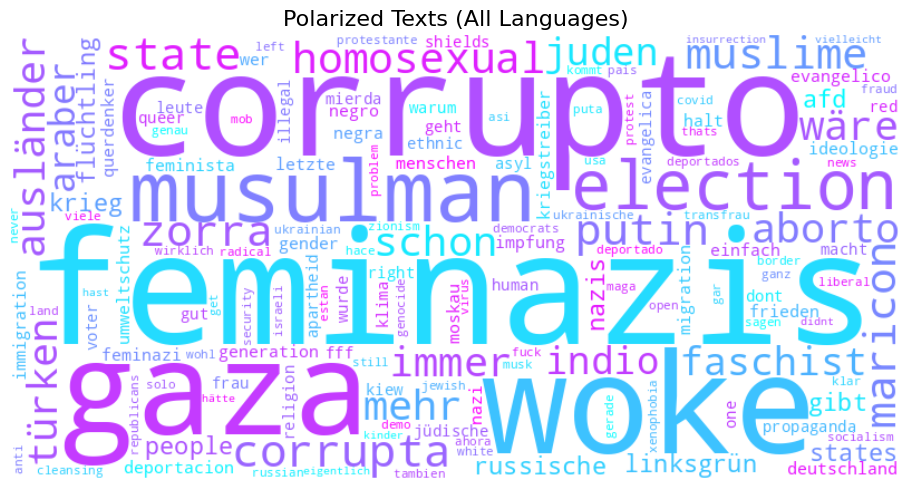

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

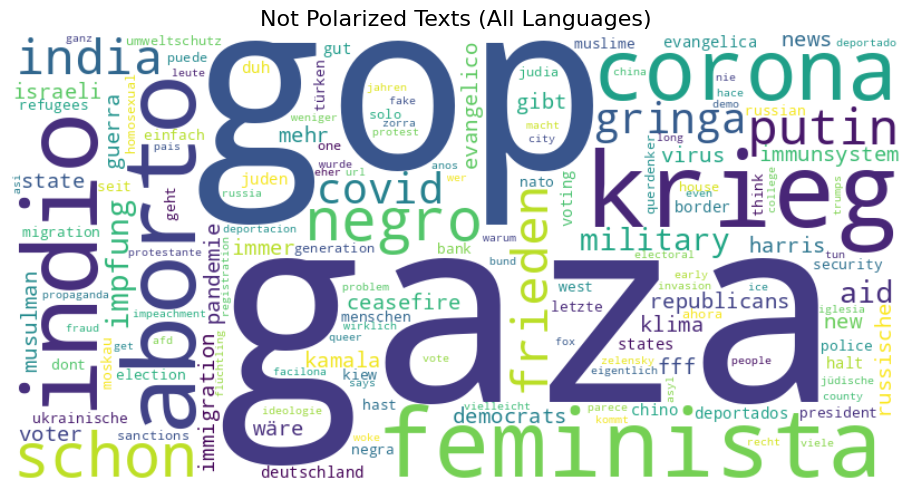

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data = pd.concat([df_eng, df_deu, df_spa], ignore_index=True)

# Combine all stop words
stop_words_all = (
    set(w.strip().lower() for w in stopwords.words('english')+['trump','ukraine','donald','joe','biden','don\'t','would','like','israel']) |
    set(w.strip().lower() for w in stopwords.words('german')+['user','russland', 'israel', 'hamas','ja','also','mal','nein']) |
    set(w.strip().lower() for w in stopwords.words('spanish')+["judio",'si','ser',"indigena", "abortar", "mas",'islam','corrupcion','israel'])
)

def clean_and_tokenize_all(text_series, stop_words):
    words = []
    for text in text_series:
        text = str(text).lower()
        text = re.sub(r'[^a-záéíóúüñäöß\s]', '', text)
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        words.extend(tokens)
    return words

polarized_texts_all = data[data['polarization'] == 1]['text']
not_polarized_texts_all = data[data['polarization'] == 0]['text']

polarized_words_all = clean_and_tokenize_all(polarized_texts_all, stop_words_all)
not_polarized_words_all = clean_and_tokenize_all(not_polarized_texts_all, stop_words_all)

polarized_counter_all = Counter(polarized_words_all)
not_polarized_counter_all = Counter(not_polarized_words_all)

# Polarized Word Cloud (All Languages)
wordcloud_pol_all = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='cool',
    max_words=150
).generate_from_frequencies(polarized_counter_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pol_all, interpolation='bilinear')
plt.axis("off")
plt.title("Polarized Texts (All Languages)", fontsize=16)
plt.tight_layout()
plt.savefig("plots/overall_wordcloud_polar.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/overall_wordcloud_polar.pdf")

# Not Polarized Word Cloud (All Languages)
wordcloud_not_all = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis',
    max_words=150
).generate_from_frequencies(not_polarized_counter_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_not_all, interpolation='bilinear')
plt.axis("off")
plt.title("Not Polarized Texts (All Languages)", fontsize=16)
plt.tight_layout()
plt.savefig("plots/overall_wordcloud_nonpolar.pdf", format="pdf", bbox_inches="tight")
plt.show()
files.download("plots/overall_wordcloud_nonpolar.pdf")


ENGLISH DATASET ANALYSIS

DATA VALIDATION & CLEANING
✓ Required columns present: ['text', 'polarization']

Initial dataset shape: (2676, 3)

Column data types:
id              object
text            object
polarization     int64
dtype: object

Missing values per column:
id              0
text            0
polarization    0
dtype: int64

✓ Data cleaned:
  - Original rows: 2676
  - Cleaned rows: 2676
  - Removed rows: 0

SAMPLE CLEANED DATA
                                    id  \
0  en_973938b90b0ff5d87d35a582f83f5c89   
1  en_07dfd4600426caca6e2c5883fcbea9ea   
2  en_f14519ff2302b6cd47712073f13bc461   
3  en_e48b7e7542faafa544ac57b64bc80daf   
4  en_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  polarization  
0           is defending imperialism in the dnd chat             0  
1  Still playing with this. I am now following Ra...             0  
2  .senate.gov Theres 3 groups out there Republic...             0  
3  "ABC MD, David Anderson, 

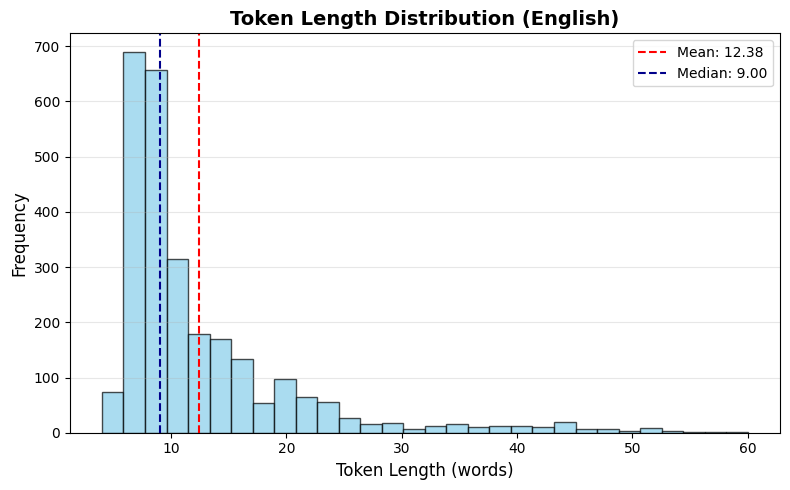


EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP
✓ Saved: plots/english/text_vs_token_length.pdf


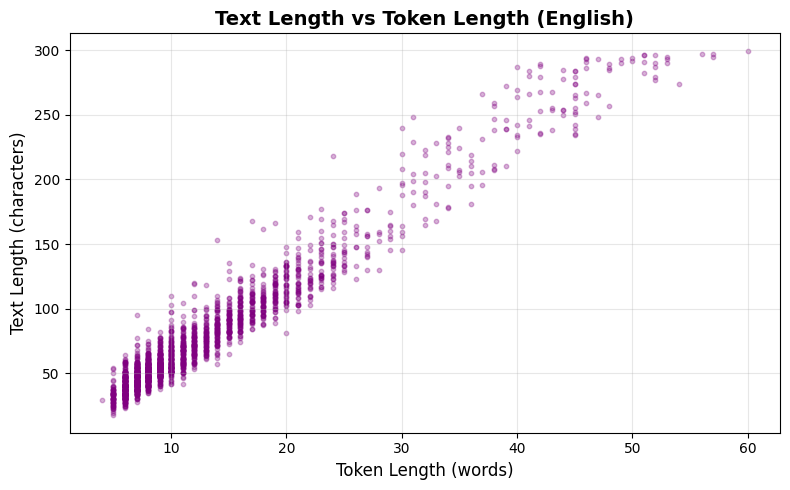


Average characters per word: 6.11
Correlation between text and token length: 0.974

TASK 3: SENTIMENT DISTRIBUTION
✓ Mapped numeric polarization to labels (0→negative, 1→positive)

Sentiment Distribution:
sentiment
negative    1674
positive    1002
Name: count, dtype: int64

Sentiment Proportions:
sentiment
negative    62.556054
positive    37.443946
Name: proportion, dtype: float64
✓ Saved: plots/english/sentiment_distribution.pdf


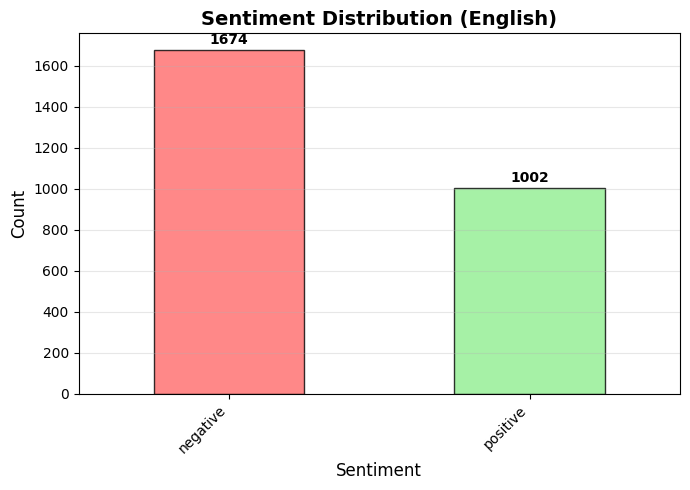


SUMMARY STATISTICS

Dataset Overview:
  - Total samples: 2676
  - Sentiment classes: 2
  - Class balance ratio: 0.60
  - Average token length: 12.38 words
  - Average text length: 75.68 characters

✓ Classes are reasonably balanced (ratio: 1.67)

ANALYSIS COMPLETE
All plots saved to: plots/english/


In [4]:
# --- English Dataset Analysis

# Create folder for saving plots
lang = "english"
os.makedirs(f"plots/{lang}", exist_ok=True)

print("="*60)
print("ENGLISH DATASET ANALYSIS")
print("="*60)

# --- DATA VALIDATION & CLEANING ---
print("\n" + "="*60)
print("DATA VALIDATION & CLEANING")
print("="*60)
eng_df = pd.read_csv("eng.csv", encoding="windows-1252")
# Check required columns
required_cols = ['text', 'polarization']
missing_cols = [col for col in required_cols if col not in eng_df.columns]
if missing_cols:
    print(f"ERROR: Missing required columns: {missing_cols}")
    print(f"Available columns: {list(eng_df.columns)}")
    exit()

print(f"✓ Required columns present: {required_cols}")

# Initial data info
print(f"\nInitial dataset shape: {eng_df.shape}")
print(f"\nColumn data types:")
print(eng_df.dtypes)

# Check for missing values
print(f"\nMissing values per column:")
print(eng_df.isnull().sum())

# Store original size
original_size = len(eng_df)

# Clean the data
# 1. Remove rows with missing text or polarization
eng_df = eng_df.dropna(subset=['text', 'polarization'])

# 2. Convert text to string and strip whitespace
eng_df['text'] = eng_df['text'].astype(str).str.strip()

# 3. Remove empty strings
eng_df = eng_df[eng_df['text'] != '']
eng_df = eng_df[eng_df['text'].str.len() > 0]

# 4. Reset index after cleaning
eng_df = eng_df.reset_index(drop=True)

cleaned_size = len(eng_df)
removed_rows = original_size - cleaned_size

print(f"\n✓ Data cleaned:")
print(f"  - Original rows: {original_size}")
print(f"  - Cleaned rows: {cleaned_size}")
print(f"  - Removed rows: {removed_rows}")

# Preview cleaned data
print("\n" + "="*60)
print("SAMPLE CLEANED DATA")
print("="*60)
print(eng_df.head())

# --- Task 1: Token Length Statistics ---
print("\n" + "="*60)
print("TASK 1: TOKEN LENGTH STATISTICS")
print("="*60)

# Calculate lengths
eng_df['text_length'] = eng_df['text'].apply(len)
eng_df['token_length'] = eng_df['text'].apply(lambda x: len(x.split()))

# Check for potential issues
zero_tokens = (eng_df['token_length'] == 0).sum()
if zero_tokens > 0:
    print(f"⚠ Warning: {zero_tokens} texts have 0 tokens (will be removed)")
    eng_df = eng_df[eng_df['token_length'] > 0]

print("\nToken Length Statistics:")
print(eng_df['token_length'].describe())

print("\nText Length (Characters) Statistics:")
print(eng_df['text_length'].describe())

# Identify outliers (texts that are unusually long)
q75 = eng_df['token_length'].quantile(0.75)
q25 = eng_df['token_length'].quantile(0.25)
iqr = q75 - q25
outlier_threshold = q75 + 1.5 * iqr
outliers = eng_df[eng_df['token_length'] > outlier_threshold]

print(f"\nOutlier Detection:")
print(f"  - IQR threshold: {outlier_threshold:.2f} tokens")
print(f"  - Number of outliers: {len(outliers)} ({len(outliers)/len(eng_df)*100:.2f}%)")

# --- Task 2: Token Length Histogram ---
print("\n" + "="*60)
print("TASK 2: TOKEN LENGTH DISTRIBUTION")
print("="*60)

plt.figure(figsize=(8, 5))
plt.hist(eng_df['token_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Token Length Distribution (English)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(eng_df['token_length'].mean(), color='red', linestyle='--',
            label=f'Mean: {eng_df["token_length"].mean():.2f}')
plt.axvline(eng_df['token_length'].median(), color='darkblue', linestyle='--',
            label=f'Median: {eng_df["token_length"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/token_length_distribution.pdf")
print(f"✓ Saved: plots/{lang}/token_length_distribution.pdf")
plt.show()

# --- Extra: Text vs Token Length Scatter Plot ---
print("\n" + "="*60)
print("EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP")
print("="*60)

plt.figure(figsize=(8, 5))
plt.scatter(eng_df['token_length'], eng_df['text_length'],
            color='purple', alpha=0.3, s=10)
plt.title('Text Length vs Token Length (English)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/text_vs_token_length.pdf")
print(f"✓ Saved: plots/{lang}/text_vs_token_length.pdf")
plt.show()

# Calculate average characters per word
avg_chars_per_word = eng_df['text_length'].sum() / eng_df['token_length'].sum()
print(f"\nAverage characters per word: {avg_chars_per_word:.2f}")

# Calculate and print correlation
correlation = eng_df['token_length'].corr(eng_df['text_length'])
print(f"Correlation between text and token length: {correlation:.3f}")

# --- Task 3: Sentiment Distribution ---
print("\n" + "="*60)
print("TASK 3: SENTIMENT DISTRIBUTION")
print("="*60)

# Map polarization to readable labels (if numeric)
if eng_df['polarization'].dtype in ['int64', 'float64']:
    sentiment_map = {0: 'negative', 1: 'positive'}
    eng_df['sentiment'] = eng_df['polarization'].map(sentiment_map)
    sentiment_col = 'sentiment'
    print("✓ Mapped numeric polarization to labels (0→negative, 1→positive)")
else:
    sentiment_col = 'polarization'
    print("✓ Using existing polarization labels")

sentiment_counts = eng_df[sentiment_col].value_counts()
print(f"\nSentiment Distribution:")
print(sentiment_counts)
print(f"\nSentiment Proportions:")
print(eng_df[sentiment_col].value_counts(normalize=True) * 100)

plt.figure(figsize=(7, 5))
colors = ['#ff6b6b', '#90ee90']  # salmon and lightgreen
sentiment_counts.plot(kind='bar', color=colors[:len(sentiment_counts)],
                      edgecolor='black', alpha=0.8)
plt.title('Sentiment Distribution (English)', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(sentiment_counts):
    plt.text(i, v + max(sentiment_counts)*0.01, str(v),
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"plots/{lang}/sentiment_distribution.pdf")
print(f"✓ Saved: plots/{lang}/sentiment_distribution.pdf")
plt.show()

# --- Summary Statistics ---
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nDataset Overview:")
print(f"  - Total samples: {len(eng_df)}")
print(f"  - Sentiment classes: {eng_df[sentiment_col].nunique()}")
print(f"  - Class balance ratio: {sentiment_counts.min() / sentiment_counts.max():.2f}")
print(f"  - Average token length: {eng_df['token_length'].mean():.2f} words")
print(f"  - Average text length: {eng_df['text_length'].mean():.2f} characters")

# Check class imbalance
max_class = sentiment_counts.max()
min_class = sentiment_counts.min()
imbalance_ratio = max_class / min_class

if imbalance_ratio > 3:
    print(f"\n⚠ WARNING: Significant class imbalance detected (ratio: {imbalance_ratio:.2f})")
    print("  Consider using techniques like oversampling, undersampling, or class weights")
else:
    print(f"\n✓ Classes are reasonably balanced (ratio: {imbalance_ratio:.2f})")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"All plots saved to: plots/{lang}/")

SPANISH DATASET ANALYSIS

DATA VALIDATION & CLEANING
✓ Required columns present: ['text', 'polarization']

Initial dataset shape: (3305, 3)

Column data types:
id              object
text            object
polarization     int64
dtype: object

Missing values per column:
id              0
text            0
polarization    0
dtype: int64

✓ Data cleaned:
  - Original rows: 3305
  - Cleaned rows: 3305
  - Removed rows: 0

SAMPLE CLEANED DATA
                                     id  \
0  spa_bc7bf0a1b710cd724cf96b5eeb020bff   
1  spa_688aec0f6abf4e0be44ecbfa886251cc   
2  spa_47019efabe7295c630bcc04bd0429230   
3  spa_8b4b244dbb90e0a813661ed12a1af5af   
4  spa_e2f37881da08b8d7b6eb07bc37356746   

                                                text  polarization  
0  "bueno, tirando"\r\ny si hay repregunta, enton...             0  
1                "caimos en su retorica de indigena"             0  
2   "cara de indigena sudaca", porque pio asi luego?             0  
3  "violar a una nina 

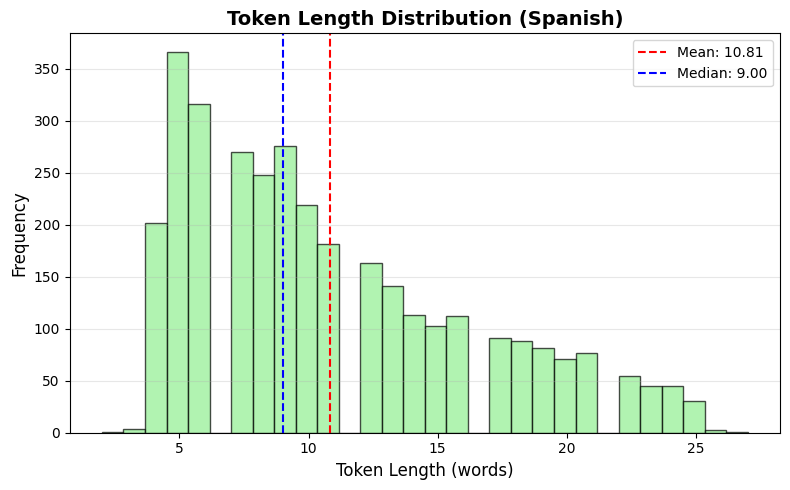


EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP
✓ Saved: plots/spanish/text_vs_token_length.pdf


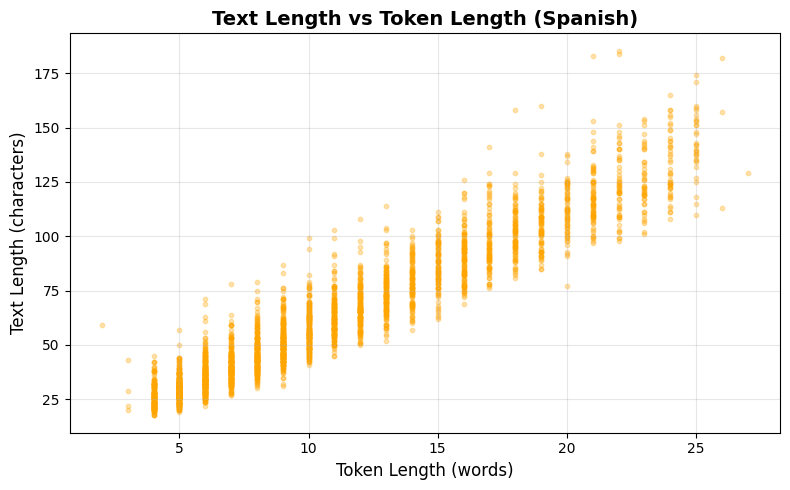


Average characters per word: 5.72

TASK 3: SENTIMENT DISTRIBUTION

Sentiment Distribution:
polarization
1    1660
0    1645
Name: count, dtype: int64

Sentiment Proportions:
polarization
1    50.226929
0    49.773071
Name: proportion, dtype: float64
✓ Saved: plots/spanish/sentiment_distribution.pdf


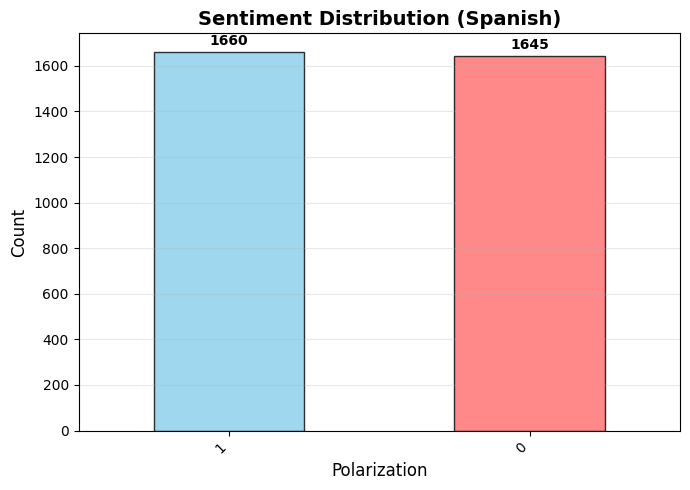


SUMMARY STATISTICS

Dataset Overview:
  - Total samples: 3305
  - Sentiment classes: 2
  - Class balance ratio: 0.99
  - Average token length: 10.81 words
  - Average text length: 61.88 characters

✓ Classes are reasonably balanced (ratio: 1.01)

ANALYSIS COMPLETE
All plots saved to: plots/spanish/


In [8]:
# --- Spanish Dataset Analysis
# Create folder for saving plots
lang = "spanish"
os.makedirs(f"plots/{lang}", exist_ok=True)
spa_df = pd.read_csv("spa.csv", encoding="utf-8-sig")
print("="*60)
print("SPANISH DATASET ANALYSIS")
print("="*60)

# --- DATA VALIDATION & CLEANING ---
print("\n" + "="*60)
print("DATA VALIDATION & CLEANING")
print("="*60)

# Check required columns
required_cols = ['text', 'polarization']
missing_cols = [col for col in required_cols if col not in spa_df.columns]
if missing_cols:
    print(f"ERROR: Missing required columns: {missing_cols}")
    print(f"Available columns: {list(spa_df.columns)}")
    exit()

print(f"✓ Required columns present: {required_cols}")

# Initial data info
print(f"\nInitial dataset shape: {spa_df.shape}")
print(f"\nColumn data types:")
print(spa_df.dtypes)

# Check for missing values
print(f"\nMissing values per column:")
print(spa_df.isnull().sum())

# Store original size
original_size = len(spa_df)

# Clean the data
# 1. Remove rows with missing text or polarization
spa_df = spa_df.dropna(subset=['text', 'polarization'])

# 2. Convert text to string and strip whitespace
spa_df['text'] = spa_df['text'].astype(str).str.strip()

# 3. Remove empty strings
spa_df = spa_df[spa_df['text'] != '']
spa_df = spa_df[spa_df['text'].str.len() > 0]

# 4. Reset index after cleaning
spa_df = spa_df.reset_index(drop=True)

cleaned_size = len(spa_df)
removed_rows = original_size - cleaned_size

print(f"\n✓ Data cleaned:")
print(f"  - Original rows: {original_size}")
print(f"  - Cleaned rows: {cleaned_size}")
print(f"  - Removed rows: {removed_rows}")

# Preview cleaned data
print("\n" + "="*60)
print("SAMPLE CLEANED DATA")
print("="*60)
print(spa_df.head())

# --- Task 1: Token Length Statistics ---
print("\n" + "="*60)
print("TASK 1: TOKEN LENGTH STATISTICS")
print("="*60)

# Calculate lengths
spa_df['text_length'] = spa_df['text'].apply(len)
spa_df['token_length'] = spa_df['text'].apply(lambda x: len(x.split()))

# Check for potential issues
zero_tokens = (spa_df['token_length'] == 0).sum()
if zero_tokens > 0:
    print(f"⚠ Warning: {zero_tokens} texts have 0 tokens (will be removed)")
    spa_df = spa_df[spa_df['token_length'] > 0]

print("\nToken Length Statistics:")
print(spa_df['token_length'].describe())

print("\nText Length (Characters) Statistics:")
print(spa_df['text_length'].describe())

# Identify outliers (texts that are unusually long)
q75 = spa_df['token_length'].quantile(0.75)
q25 = spa_df['token_length'].quantile(0.25)
iqr = q75 - q25
outlier_threshold = q75 + 1.5 * iqr
outliers = spa_df[spa_df['token_length'] > outlier_threshold]

print(f"\nOutlier Detection:")
print(f"  - IQR threshold: {outlier_threshold:.2f} tokens")
print(f"  - Number of outliers: {len(outliers)} ({len(outliers)/len(spa_df)*100:.2f}%)")

# --- Task 2: Token Length Histogram ---
print("\n" + "="*60)
print("TASK 2: TOKEN LENGTH DISTRIBUTION")
print("="*60)

plt.figure(figsize=(8, 5))
plt.hist(spa_df['token_length'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Token Length Distribution (Spanish)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(spa_df['token_length'].mean(), color='red', linestyle='--',
            label=f'Mean: {spa_df["token_length"].mean():.2f}')
plt.axvline(spa_df['token_length'].median(), color='blue', linestyle='--',
            label=f'Median: {spa_df["token_length"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/token_length_distribution.pdf")
print(f"✓ Saved: plots/{lang}/token_length_distribution.pdf")
plt.show()

# --- Extra: Text vs Token Length Scatter Plot ---
print("\n" + "="*60)
print("EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP")
print("="*60)

plt.figure(figsize=(8, 5))
plt.scatter(spa_df['token_length'], spa_df['text_length'],
            color='orange', alpha=0.3, s=10)
plt.title('Text Length vs Token Length (Spanish)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/text_vs_token_length.pdf")
print(f"✓ Saved: plots/{lang}/text_vs_token_length.pdf")
plt.show()

# Calculate average characters per word
avg_chars_per_word = spa_df['text_length'].sum() / spa_df['token_length'].sum()
print(f"\nAverage characters per word: {avg_chars_per_word:.2f}")

# --- Task 3: Sentiment Distribution ---
print("\n" + "="*60)
print("TASK 3: SENTIMENT DISTRIBUTION")
print("="*60)

sentiment_counts = spa_df['polarization'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)
print("\nSentiment Proportions:")
print(spa_df['polarization'].value_counts(normalize=True) * 100)

plt.figure(figsize=(7, 5))
colors = ['#87ceeb', '#ff6b6b', '#95d5b2']
sentiment_counts.plot(kind='bar', color=colors[:len(sentiment_counts)],
                      edgecolor='black', alpha=0.8)
plt.title('Sentiment Distribution (Spanish)', fontsize=14, fontweight='bold')
plt.xlabel('Polarization', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
# Add count labels on bars
for i, v in enumerate(sentiment_counts):
    plt.text(i, v + max(sentiment_counts)*0.01, str(v),
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"plots/{lang}/sentiment_distribution.pdf")
print(f"✓ Saved: plots/{lang}/sentiment_distribution.pdf")
plt.show()

# --- Summary Statistics ---
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nDataset Overview:")
print(f"  - Total samples: {len(spa_df)}")
print(f"  - Sentiment classes: {spa_df['polarization'].nunique()}")
print(f"  - Class balance ratio: {sentiment_counts.min() / sentiment_counts.max():.2f}")
print(f"  - Average token length: {spa_df['token_length'].mean():.2f} words")
print(f"  - Average text length: {spa_df['text_length'].mean():.2f} characters")

# Check class imbalance
max_class = sentiment_counts.max()
min_class = sentiment_counts.min()
imbalance_ratio = max_class / min_class

if imbalance_ratio > 3:
    print(f"\n⚠ WARNING: Significant class imbalance detected (ratio: {imbalance_ratio:.2f})")
    print("  Consider using techniques like oversampling, undersampling, or class weights")
else:
    print(f"\n✓ Classes are reasonably balanced (ratio: {imbalance_ratio:.2f})")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"All plots saved to: plots/{lang}/")

GERMAN DATASET ANALYSIS
✓ Dataset loaded successfully: 3180 rows

DATA VALIDATION & CLEANING
✓ Required columns present: ['text', 'polarization']

Initial dataset shape: (3180, 3)

Column data types:
id              object
text            object
polarization     int64
dtype: object

Missing values per column:
id              0
text            0
polarization    0
dtype: int64

✓ Data cleaned:
  - Original rows: 3180
  - Cleaned rows: 3180
  - Removed rows: 0

SAMPLE CLEANED DATA
                                     id  \
0  deu_fa07b0533db91281c049fb722ca121d7   
1  deu_10e753b5d49374d2de1f68dfc1e2d249   
2  deu_61be00002367a33400dade564edccc59   
3  deu_d28b20af64d590134448fcdbfbb0f7dd   
4  deu_005fc728be211eae1c308a0fc20d73df   

                                                text  polarization  
0  Natürlich bin ich linksgrün - ich habe Herz u n d             0  
1  Schuld sind Habeck,  die grünen und diese link...             1  
2  Vielleicht ist da ja tatsächlich was dran. Höc..

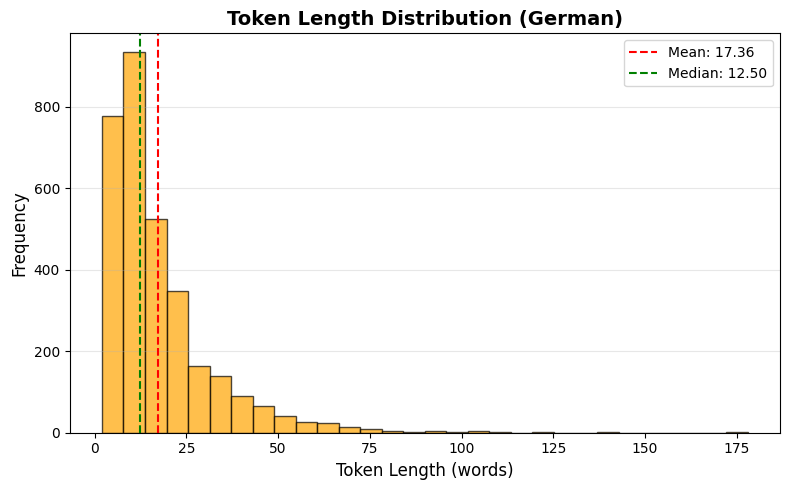


EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP
✓ Saved: plots/german/text_vs_token_length.pdf


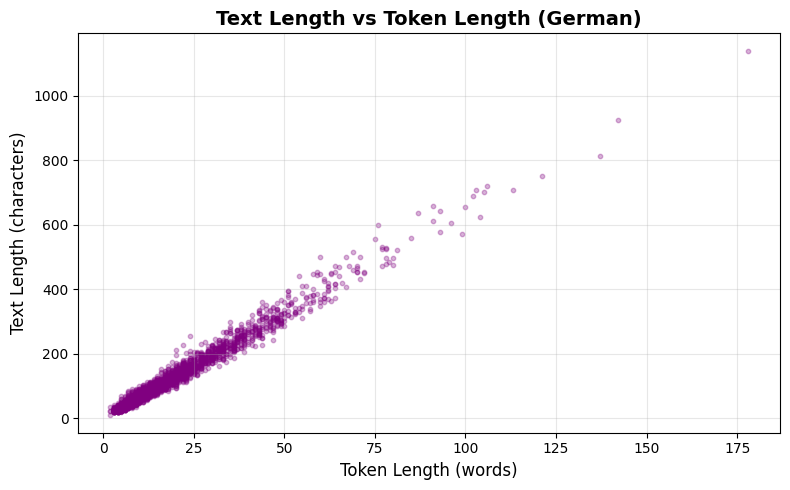


Average characters per word: 6.56

TASK 3: SENTIMENT DISTRIBUTION

Sentiment Distribution:
polarization
0    1668
1    1512
Name: count, dtype: int64

Sentiment Proportions:
polarization
0    52.45283
1    47.54717
Name: proportion, dtype: float64
✓ Saved: plots/german/sentiment_distribution.pdf


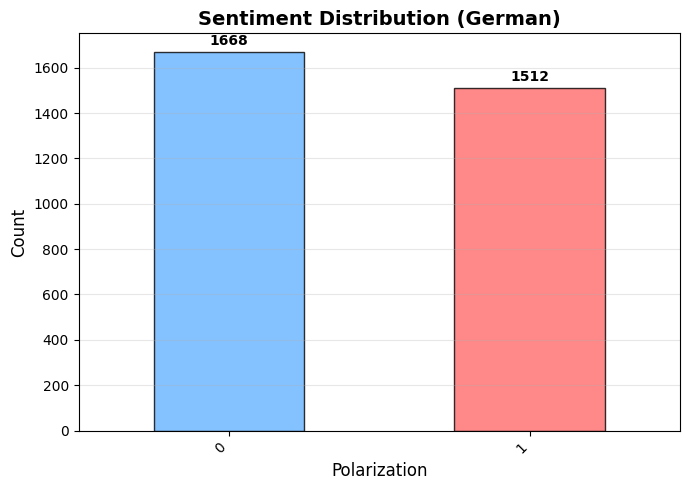


SUMMARY STATISTICS

Dataset Overview:
  - Total samples: 3180
  - Sentiment classes: 2
  - Class balance ratio: 0.91
  - Average token length: 17.36 words
  - Average text length: 113.94 characters

✓ Classes are reasonably balanced (ratio: 1.10)

ANALYSIS COMPLETE
All plots saved to: plots/german/


In [9]:
# --- German Dataset Analysis
# Create folder for saving plots
lang = "german"
os.makedirs(f"plots/{lang}", exist_ok=True)


print("="*60)
print("GERMAN DATASET ANALYSIS")
print("="*60)

# Load German dataset
try:
    deu_df = pd.read_csv("deu.csv", encoding="utf-8")
    print(f"✓ Dataset loaded successfully: {len(deu_df)} rows")
except FileNotFoundError:
    print("ERROR: File 'deu.csv' not found!")
    exit()

# --- DATA VALIDATION & CLEANING ---
print("\n" + "="*60)
print("DATA VALIDATION & CLEANING")
print("="*60)

# Check required columns
required_cols = ['text', 'polarization']
missing_cols = [col for col in required_cols if col not in deu_df.columns]
if missing_cols:
    print(f"ERROR: Missing required columns: {missing_cols}")
    print(f"Available columns: {list(deu_df.columns)}")
    exit()

print(f"✓ Required columns present: {required_cols}")

# Initial data info
print(f"\nInitial dataset shape: {deu_df.shape}")
print(f"\nColumn data types:")
print(deu_df.dtypes)

# Check for missing values
print(f"\nMissing values per column:")
print(deu_df.isnull().sum())

# Store original size
original_size = len(deu_df)

# Clean the data
# 1. Remove rows with missing text or polarization
deu_df = deu_df.dropna(subset=['text', 'polarization'])

# 2. Convert text to string and strip whitespace
deu_df['text'] = deu_df['text'].astype(str).str.strip()

# 3. Remove empty strings
deu_df = deu_df[deu_df['text'] != '']
deu_df = deu_df[deu_df['text'].str.len() > 0]

# 4. Reset index after cleaning
deu_df = deu_df.reset_index(drop=True)

cleaned_size = len(deu_df)
removed_rows = original_size - cleaned_size

print(f"\n✓ Data cleaned:")
print(f"  - Original rows: {original_size}")
print(f"  - Cleaned rows: {cleaned_size}")
print(f"  - Removed rows: {removed_rows}")

# Preview cleaned data
print("\n" + "="*60)
print("SAMPLE CLEANED DATA")
print("="*60)
print(deu_df.head())

# --- Task 1: Token Length Statistics ---
print("\n" + "="*60)
print("TASK 1: TOKEN LENGTH STATISTICS")
print("="*60)

# Calculate lengths
deu_df['text_length'] = deu_df['text'].apply(len)
deu_df['token_length'] = deu_df['text'].apply(lambda x: len(x.split()))

# Check for potential issues
zero_tokens = (deu_df['token_length'] == 0).sum()
if zero_tokens > 0:
    print(f"⚠ Warning: {zero_tokens} texts have 0 tokens (will be removed)")
    deu_df = deu_df[deu_df['token_length'] > 0]

print("\nToken Length Statistics:")
print(deu_df['token_length'].describe())

print("\nText Length (Characters) Statistics:")
print(deu_df['text_length'].describe())

# Identify outliers (texts that are unusually long)
q75 = deu_df['token_length'].quantile(0.75)
q25 = deu_df['token_length'].quantile(0.25)
iqr = q75 - q25
outlier_threshold = q75 + 1.5 * iqr
outliers = deu_df[deu_df['token_length'] > outlier_threshold]

print(f"\nOutlier Detection:")
print(f"  - IQR threshold: {outlier_threshold:.2f} tokens")
print(f"  - Number of outliers: {len(outliers)} ({len(outliers)/len(deu_df)*100:.2f}%)")

# --- Task 2: Token Length Histogram ---
print("\n" + "="*60)
print("TASK 2: TOKEN LENGTH DISTRIBUTION")
print("="*60)

plt.figure(figsize=(8, 5))
plt.hist(deu_df['token_length'], bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.title('Token Length Distribution (German)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(deu_df['token_length'].mean(), color='red', linestyle='--',
            label=f'Mean: {deu_df["token_length"].mean():.2f}')
plt.axvline(deu_df['token_length'].median(), color='green', linestyle='--',
            label=f'Median: {deu_df["token_length"].median():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/token_length_distribution.pdf")
print(f"✓ Saved: plots/{lang}/token_length_distribution.pdf")
plt.show()

# --- Extra: Text vs Token Length Scatter Plot ---
print("\n" + "="*60)
print("EXTRA: TEXT VS TOKEN LENGTH RELATIONSHIP")
print("="*60)

plt.figure(figsize=(8, 5))
plt.scatter(deu_df['token_length'], deu_df['text_length'],
            color='purple', alpha=0.3, s=10)
plt.title('Text Length vs Token Length (German)', fontsize=14, fontweight='bold')
plt.xlabel('Token Length (words)', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/{lang}/text_vs_token_length.pdf")
print(f"✓ Saved: plots/{lang}/text_vs_token_length.pdf")
plt.show()

# Calculate average characters per word
avg_chars_per_word = deu_df['text_length'].sum() / deu_df['token_length'].sum()
print(f"\nAverage characters per word: {avg_chars_per_word:.2f}")

# --- Task 3: Sentiment Distribution ---
print("\n" + "="*60)
print("TASK 3: SENTIMENT DISTRIBUTION")
print("="*60)

sentiment_counts = deu_df['polarization'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)
print("\nSentiment Proportions:")
print(deu_df['polarization'].value_counts(normalize=True) * 100)

plt.figure(figsize=(7, 5))
colors = ['#66b3ff', '#ff6b6b', '#95d5b2']
sentiment_counts.plot(kind='bar', color=colors[:len(sentiment_counts)],
                      edgecolor='black', alpha=0.8)
plt.title('Sentiment Distribution (German)', fontsize=14, fontweight='bold')
plt.xlabel('Polarization', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(sentiment_counts):
    plt.text(i, v + max(sentiment_counts)*0.01, str(v),
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"plots/{lang}/sentiment_distribution.pdf")
print(f"✓ Saved: plots/{lang}/sentiment_distribution.pdf")
plt.show()

# --- Summary Statistics ---
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nDataset Overview:")
print(f"  - Total samples: {len(deu_df)}")
print(f"  - Sentiment classes: {deu_df['polarization'].nunique()}")
print(f"  - Class balance ratio: {sentiment_counts.min() / sentiment_counts.max():.2f}")
print(f"  - Average token length: {deu_df['token_length'].mean():.2f} words")
print(f"  - Average text length: {deu_df['text_length'].mean():.2f} characters")

# Check class imbalance
max_class = sentiment_counts.max()
min_class = sentiment_counts.min()
imbalance_ratio = max_class / min_class

if imbalance_ratio > 3:
    print(f"\n⚠ WARNING: Significant class imbalance detected (ratio: {imbalance_ratio:.2f})")
    print("  Consider using techniques like oversampling, undersampling, or class weights")
else:
    print(f"\n✓ Classes are reasonably balanced (ratio: {imbalance_ratio:.2f})")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"All plots saved to: plots/{lang}/")

In [3]:
# --- Combined Multi-Language Dataset Analysis
print("="*60)
print("COMBINED MULTI-LANGUAGE DATASET ANALYSIS")
print("="*60)

# Create the plots folder if it doesn't exist
os.makedirs("plots", exist_ok=True)

# --- LOAD AND COMBINE ALL DATASETS ---
print("\n" + "="*60)
print("LOADING DATASETS")
print("="*60)

datasets = []
languages = ['english', 'spanish', 'german']
file_names = {'english': 'eng.csv', 'spanish': 'spa.csv', 'german': 'deu.csv'}

for lang in languages:
    try:
        file_path = f"{file_names[lang]}"
        temp_df = pd.read_csv(file_path, encoding="utf-8")
        temp_df['language'] = lang
        datasets.append(temp_df)
        print(f"✓ Loaded {lang}: {len(temp_df)} rows")
    except FileNotFoundError:
        print(f"⚠ Warning: File '{file_path}' not found. Skipping {lang}.")
    except Exception as e:
        print(f"⚠ Error loading {lang}: {e}")

if not datasets:
    print("ERROR: No datasets were loaded successfully!")
    exit()

# Combine all datasets
df = pd.concat(datasets, ignore_index=True)
print(f"\n✓ Combined dataset created: {len(df)} total rows")

# --- DATA VALIDATION & CLEANING ---
print("\n" + "="*60)
print("DATA VALIDATION & CLEANING")
print("="*60)

# Check required columns
required_cols = ['text', 'polarization', 'language']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"ERROR: Missing required columns: {missing_cols}")
    exit()

print(f"✓ Required columns present: {required_cols}")

# Store original size
original_size = len(df)

# Clean the data
# 1. Remove rows with missing text or polarization
df = df.dropna(subset=['text', 'polarization'])

# 2. Convert text to string and strip whitespace
df['text'] = df['text'].astype(str).str.strip()

# 3. Remove empty strings
df = df[df['text'] != '']
df = df[df['text'].str.len() > 0]

# 4. Reset index after cleaning
df = df.reset_index(drop=True)

cleaned_size = len(df)
removed_rows = original_size - cleaned_size

print(f"\n✓ Data cleaned:")
print(f"  - Original rows: {original_size}")
print(f"  - Cleaned rows: {cleaned_size}")
print(f"  - Removed rows: {removed_rows}")

# --- CALCULATE TOKEN STATISTICS ---
print("\n" + "="*60)
print("CALCULATING TOKEN STATISTICS")
print("="*60)

df['text_length'] = df['text'].apply(len)
df['token_length'] = df['text'].apply(lambda x: len(x.split()))

# Remove zero-token texts
zero_tokens = (df['token_length'] == 0).sum()
if zero_tokens > 0:
    print(f"⚠ Warning: Removing {zero_tokens} texts with 0 tokens")
    df = df[df['token_length'] > 0]

# Calculate statistics per language
token_stats = df.groupby('language')['token_length'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nToken Length Statistics per Language:")
print(token_stats)

# --- MERGE INDIVIDUAL LANGUAGE PDFs ---
print("\n" + "="*60)
print("MERGING INDIVIDUAL LANGUAGE PDFs")
print("="*60)

pdf_files = []
for lang in languages:
    for plot_type in ['token_length_distribution', 'text_vs_token_length', 'sentiment_distribution']:
        pdf_path = f"plots/{lang}/{plot_type}.pdf"
        if os.path.exists(pdf_path):
            pdf_files.append(pdf_path)
        else:
            print(f"⚠ Warning: File not found: {pdf_path}")

if pdf_files:
    try:
        merger = PdfMerger()
        for pdf in pdf_files:
            merger.append(pdf)
        output_path = "plots/separate_lang_graphs.pdf"
        merger.write(output_path)
        merger.close()
        print(f"✓ Successfully merged {len(pdf_files)} PDFs into '{output_path}'")
    except Exception as e:
        print(f"⚠ Error merging PDFs: {e}")
else:
    print("⚠ No individual language PDFs found to merge")

# --- CREATE COMBINED COMPARISON PLOTS ---
print("\n" + "="*60)
print("CREATING COMBINED COMPARISON PLOTS")
print("="*60)

# Save all combined graphs to a single PDF
with PdfPages("plots/combined_graphs.pdf") as pdf:

    # === Plot 1: Token Length Distribution (Boxplot) ===
    print("Creating Plot 1: Token Length Boxplot...")
    plt.figure(figsize=(10, 6))

    # Create boxplot with better styling
    bp = df.boxplot(column="token_length", by="language", grid=False,
                     patch_artist=True, return_type='dict')

    # Color the boxes
    colors = ['#66c2a5', '#fc8d62', '#8da0cb']
    for patch, color in zip(bp['token_length']['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    plt.suptitle("")  # Remove automatic title
    plt.title("Token Length Distribution per Language", fontsize=14, fontweight='bold', pad=20)
    plt.xlabel("Language", fontsize=12)
    plt.ylabel("Token Length (words)", fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    print("✓ Plot 1 saved")

    # === Plot 2: Average Token Length (Bar Chart) ===
    print("Creating Plot 2: Average Token Length Bar Chart...")
    plt.figure(figsize=(10, 6))

    ax = token_stats["mean"].plot(kind="bar", color=colors, edgecolor='black', alpha=0.8)
    plt.title("Average Token Length per Language", fontsize=14, fontweight='bold')
    plt.xlabel("Language", fontsize=12)
    plt.ylabel("Average Token Length (words)", fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(token_stats["mean"]):
        ax.text(i, v + token_stats["mean"].max()*0.01, f'{v:.2f}',
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    pdf.savefig()
    plt.close()
    print("✓ Plot 2 saved")

    # === Plot 3: Sentiment Distribution Across Languages ===
    print("Creating Plot 3: Sentiment Distribution...")
    plt.figure(figsize=(10, 6))

    # Create sentiment distribution
    sentiment_dist = df.groupby(["language", "polarization"]).size().unstack(fill_value=0)

    ax = sentiment_dist.plot(kind="bar", stacked=True,
                              color=['#ff6b6b', '#90ee90'],
                              edgecolor='black', alpha=0.8)
    plt.title("Sentiment Distribution Across Languages", fontsize=14, fontweight='bold')
    plt.xlabel("Language", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend(title="Polarization", labels=['Negative', 'Positive'],
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    print("✓ Plot 3 saved")

    # === Plot 4: Token Length Distribution (Histogram Overlay) ===
    print("Creating Plot 4: Token Length Histogram Comparison...")
    plt.figure(figsize=(10, 6))

    for lang, color in zip(languages, colors):
        lang_data = df[df['language'] == lang]['token_length']
        plt.hist(lang_data, bins=30, alpha=0.5, label=lang.capitalize(),
                color=color, edgecolor='black')

    plt.title("Token Length Distribution Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Token Length (words)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    print("✓ Plot 4 saved")

    # === Plot 5: Average Text vs Token Length per Language ===
    print("Creating Plot 5: Text vs Token Length Comparison...")
    plt.figure(figsize=(10, 6))

    for lang, color in zip(languages, colors):
        lang_data = df[df['language'] == lang]
        plt.scatter(lang_data['token_length'], lang_data['text_length'],
                   alpha=0.3, label=lang.capitalize(), color=color, s=10)

    plt.title("Text Length vs Token Length (All Languages)", fontsize=14, fontweight='bold')
    plt.xlabel("Token Length (words)", fontsize=12)
    plt.ylabel("Text Length (characters)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    print("✓ Plot 5 saved")

print("\n✓ All combined graphs saved to 'plots/combined_graphs.pdf'")

# --- SUMMARY STATISTICS ---
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nOverall Dataset:")
print(f"  - Total samples: {len(df)}")
print(f"  - Languages: {df['language'].nunique()}")

print(f"\nSamples per Language:")
for lang in languages:
    count = len(df[df['language'] == lang])
    pct = count / len(df) * 100
    print(f"  - {lang.capitalize()}: {count} ({pct:.1f}%)")

print(f"\nAverage Characters per Word:")
for lang in languages:
    lang_data = df[df['language'] == lang]
    avg_chars = lang_data['text_length'].sum() / lang_data['token_length'].sum()
    print(f"  - {lang.capitalize()}: {avg_chars:.2f}")

print(f"\nSentiment Balance per Language:")
for lang in languages:
    lang_data = df[df['language'] == lang]
    sentiment_counts = lang_data['polarization'].value_counts()
    if len(sentiment_counts) > 1:
        balance = sentiment_counts.min() / sentiment_counts.max()
        print(f"  - {lang.capitalize()}: {balance:.2f} (1.0 = perfect balance)")
    else:
        print(f"  - {lang.capitalize()}: Only one sentiment class present")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"Output files:")
print(f"  - plots/combined_graphs.pdf (5 comparison plots)")
print(f"  - plots/separate_lang_graphs.pdf (individual language plots merged)")

COMBINED MULTI-LANGUAGE DATASET ANALYSIS

LOADING DATASETS
✓ Loaded english: 2676 rows
✓ Loaded spanish: 3305 rows
✓ Loaded german: 3180 rows

✓ Combined dataset created: 9161 total rows

DATA VALIDATION & CLEANING
✓ Required columns present: ['text', 'polarization', 'language']

✓ Data cleaned:
  - Original rows: 9161
  - Cleaned rows: 9161
  - Removed rows: 0

CALCULATING TOKEN STATISTICS

Token Length Statistics per Language:
               mean  median        std  min  max
language                                        
english   12.379297     9.0   8.447972    4   60
german    17.360692    12.5  15.094452    2  178
spanish   10.813011     9.0   5.482098    2   27

MERGING INDIVIDUAL LANGUAGE PDFs
⚠ Error merging PDFs: name 'PdfMerger' is not defined

CREATING COMBINED COMPARISON PLOTS
Creating Plot 1: Token Length Boxplot...
✓ Plot 1 saved
Creating Plot 2: Average Token Length Bar Chart...
✓ Plot 2 saved
Creating Plot 3: Sentiment Distribution...
✓ Plot 3 saved
Creating Plot 4: T

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>